In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import joblib

In [ ]:
df = pd.read_csv('../Data/Real_Estate_Model.csv')
print(df.shape)

In [ ]:
df[['price', 'bath', 'house_size', 'bed', 'Price_per_sqft']].corr()

Variable Selection and train model

In [3]:
#change data type of city, state, and zip_code to category
df['city'] = df['city'].astype('category')
df['state'] = df['state'].astype('category')
df['zip_code'] = df['zip_code'].astype('category')
df['bed'] = df['bed'].astype(int)
df['bath'] = df['bath'].astype(int)

In [ ]:
df.dtypes

Base Model

In [ ]:
X = df[['bath', 'bed', 'house_size', 'state', 'city']]
y = df['price']
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=6)
base_model = xgb.XGBRegressor(enable_categorical=True).fit(X_train, Y_train)
base_pred = base_model.predict(X_test)
mae_base = mean_absolute_error(Y_test, base_pred)
rmse_base = np.sqrt(mean_squared_error(Y_test, base_pred))  
r2_base = r2_score(Y_test, base_pred)
mape_base = np.mean(np.abs((Y_test - base_pred) / Y_test)) * 100  
print(f"MAE: {mae_base}")
print(f"RMSE: {rmse_base}")
print(f"MAPE: {mape_base}")
print(f"R2: {r2_base}")

MAE: 83998.45450349248
RMSE: 116517.001734712
MAPE: 29.349247701331045
R2: 0.7119814417129566


Feature Importance

In [ ]:
residuals = Y_test - base_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

feature_importance = base_model.feature_importances_
features = X.columns
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of the Best Model')
plt.show()

Hyper parameter tuning: Find optimal combination of parameters to decrease the average percentage error rate. It includes cross validation in the process.  

In [31]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [2,4,6],
    'learning_rate': [0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300]
}

grid_search = GridSearchCV(estimator=xgb.XGBRegressor(enable_categorical=True), param_grid=param_grid, cv=2, scoring='neg_mean_absolute_percentage_error', verbose=1)
grid_search.fit(X_train, Y_train)

best_model = grid_search.best_estimator_
best_pred = best_model.predict(X_test)

mae_best = mean_absolute_error(Y_test, best_pred)
rmse_best = np.sqrt(mean_squared_error(Y_test, best_pred))
mape_best = np.mean(np.abs((Y_test - best_pred) / Y_test)) * 100
r2_best = r2_score(Y_test, best_pred)

print(f"MAE: {mae_best}, RMSE: {rmse_best}, MAPE: {mape_best}, R2: {r2_best}")

Fitting 2 folds for each of 27 candidates, totalling 54 fits
MAE: 77186.1336609868, RMSE: 110200.426890399, MAPE: 26.330857101827753, R2: 0.7423628866164432


In [ ]:
print("\nBest parameters found by GridSearchCV:")
print(grid_search.best_params_)

Best Model

In [ ]:
best_model = xgb.XGBRegressor(learning_rate=0.3, max_depth=3, n_estimators=800, enable_categorical=True).fit(X_train, Y_train)
best_pred = best_model.predict(X_test)

mae_best = mean_absolute_error(Y_test, best_pred)
rmse_best = np.sqrt(mean_squared_error(Y_test, best_pred))
mape_best = np.mean(np.abs((Y_test - best_pred) / Y_test)) * 100
r2_besst = r2_score(Y_test, best_pred)
print(f"MAE: {mae_best}, RMSE: {rmse_best}, MAPE: {mape_best}, R2: {r2_besst}")


MAE: 85551.74140117777, RMSE: 118373.90162169954, MAPE: 29.91919928249733, R2: 0.7027281434989712


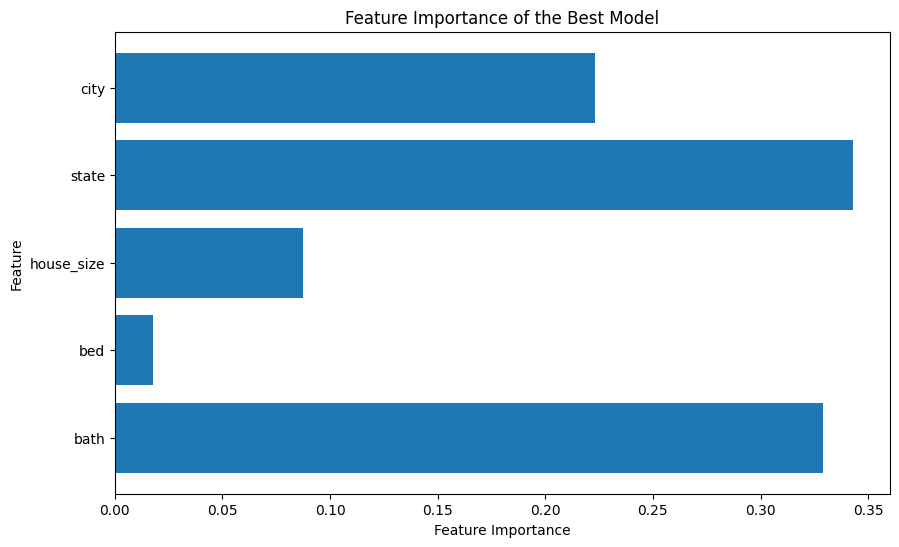

In [24]:
best_feature_importance = best_model.feature_importances_
features = X.columns
plt.figure(figsize=(10, 6))
plt.barh(features, best_feature_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of the Best Model')
plt.show()

In [33]:
bins = [0, 300_000, 400_000, 500_000, 1_000_000, float('inf')]
labels = ['<300k', '300k-400k', '400k-500k', '500k-1M', '1M+']

price_segments = pd.cut(Y_test, bins=bins, labels=labels)
segment_df = pd.DataFrame({'actual': Y_test, 'pred': best_pred, 'segment': price_segments})
segment_df['pct_error'] = np.abs(segment_df['actual'] - segment_df['pred']) / segment_df['actual'] * 100

mape_by_segment = segment_df.groupby('segment')['pct_error'].mean()
print(mape_by_segment)

segment
<300k        40.198400
300k-400k    17.526344
400k-500k    15.822385
500k-1M      16.226168
1M+                NaN
Name: pct_error, dtype: float64


C:\Users\tomas\AppData\Local\Temp\ipykernel_6532\1603868989.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mape_by_segment = segment_df.groupby('segment')['pct_error'].mean()


Save model

In [ ]:
joblib.dump((best_model, X.columns), 'Best_Model.pkl')

Model for houses below 300k

In [ ]:
low_model = df[df['price'] <= 300000]
X_low = low_model[['state', 'city', 'bath', 'bed', 'house_size']]
y_low = low_model['price']
X_low_train, X_low_test, Y_low_train, Y_low_test = train_test_split(X_low, y_low, test_size=0.2, random_state=52)
xgb_low_model = xgb.XGBRegressor(learning_rate=0.1, max_depth=10, n_estimators=800, tree_method = 'hist', early_stopping_rounds = 50,  enable_categorical=True).fit(X_low_train, Y_low_train, eval_set=[(X_low_test, Y_low_test)], verbose=1)
low_pred = xgb_low_model.predict(X_low_test)
mae_low = mean_absolute_error(Y_low_test, low_pred)
rmse_low = np.sqrt(mean_squared_error(Y_low_test, low_pred))
mape_low = np.mean(np.abs((Y_low_test - low_pred) / Y_low_test)) * 100
r2_low = r2_score(Y_low_test, low_pred)
print(f"MAE: {mae_low}, RMSE: {rmse_low}, MAPE: {mape_low}, R2: {r2_low}")
low_feature_importance = xgb_low_model.feature_importances_
features = X_low.columns
plt.figure(figsize=(10, 6))
plt.barh(features, low_feature_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of the Low Price Model')
plt.show()

Hyper parameter tuning for model with houses below $300,000. It includes cross validation in the process.

In [ ]:
param_grid_low = {
    'max_depth': [2, 4],
    'learning_rate': [0.1, 0.3],
    'n_estimators': [200, 400]
}
grid_search_low = GridSearchCV(estimator=xgb_low_model, param_grid=param_grid_low, cv=3, scoring='neg_mean_absolute_percentage_error', verbose=1)
grid_search_low.fit(X_low_train, Y_low_train, eval_set=[(X_low_test, Y_low_test)], verbose=1)
print("Best parameters found for low price model: ", grid_search_low.best_params_)
best_low_model = grid_search_low.best_estimator_
best_low_pred = best_low_model.predict(X_low_test)
mae_low = mean_absolute_error(Y_low_test, best_low_pred)
rmse_low = np.sqrt(mean_squared_error(Y_low_test, best_low_pred))
mape_low = np.mean(np.abs((Y_low_test - best_low_pred) / Y_low_test)) * 100
r2_low = r2_score(Y_low_test, best_low_pred)
print(f"MAE: {mae_low}, RMSE: {rmse_low}, MAPE: {mape_low}, R2: {r2_low}")


In [14]:

print("Best parameters found: ", grid_search_low.best_params_)
print("Best score: ", grid_search_low.best_score_)

Best parameters found:  {'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 400}
Best score:  -0.256232974216861


In [ ]:
best_low_model = xgb.XGBRegressor(learning_rate=0.1, max_depth=8, n_estimators=800, tree_method = 'hist', early_stopping_rounds = 50,  enable_categorical=True).fit(X_low_train, Y_low_train, eval_set=[(X_low_test, Y_low_test)], verbose=1)
best_low_pred = best_low_model.predict(X_low_test)
mae_low_best = mean_absolute_error(Y_low_test, best_low_pred)
rmse_low_best = np.sqrt(mean_squared_error(Y_low_test, best_low_pred))
mape_low_best = np.mean(np.abs((Y_low_test - best_low_pred) / Y_low_test)) * 100
r2_low_best = r2_score(Y_low_test, best_low_pred)
print(f"MAE: {mae_low_best}, RMSE: {rmse_low_best}, MAPE: {mape_low_best}, R2: {r2_low_best}")

Save low model

In [15]:
joblib.dump((best_model, X_low), 'Best_low_model.pkl')

['Best_low_model.pkl']